In [1]:
import pandas as pd
sampled_data = pd.read_csv('sex_dataset.csv')

female_approved_mask = (sampled_data['derived_sex'] == 0.0) & (sampled_data['action_taken'] == 1.0)

# Calculate 15% of these entries to change to 'Denied'
num_to_change = int(np.ceil(black_approved_mask.sum() * 0.20))

# Randomly select 15% of these entries and change their 'action_taken' status to 'Denied'
change_indices = race_dataset[female_approved_mask].sample(n=num_to_change, random_state=42).index
race_dataset.loc[change_indices, 'action_taken'] = 0.0

# Now, the data has 15% more black people who are denied a loan
race_dataset.to_csv("added_sex_bias.csv", index=False)
sampled_data = pd.read_csv('added_sex_bias.csv')

In [2]:
import numpy as np

def calculate_confusion_matrix(y_true, y_pred, group):
    # Ensure that group is a boolean array for indexing
    group = group.astype(bool)

    # Filter the predictions and true values based on the group
    y_true_group = y_true[group]
    y_pred_group = y_pred[group]

    # Calculate true positives, false positives, true negatives, and false negatives
    tp = np.sum((y_pred_group == 1) & (y_true_group == 1))
    tn = np.sum((y_pred_group == 0) & (y_true_group == 0))
    fp = np.sum((y_pred_group == 1) & (y_true_group == 0))
    fn = np.sum((y_pred_group == 0) & (y_true_group == 1))

    return tp, tn, fp, fn

def EqualOpportunityDifference(y, pred, group_a, group_b):
    tp_a, _, _, fn_a = calculate_confusion_matrix(y, pred, group_a)
    tp_b, _, _, fn_b = calculate_confusion_matrix(y, pred, group_b)
    tpr_a = tp_a / (tp_a + fn_a) if (tp_a + fn_a) > 0 else 0
    tpr_b = tp_b / (tp_b + fn_b) if (tp_b + fn_b) > 0 else 0
    return tpr_b - tpr_a

def FalsePositiveRateBalance(y, pred, group_a, group_b):
    _, tn_a, fp_a, _ = calculate_confusion_matrix(y, pred, group_a)
    _, tn_b, fp_b, _ = calculate_confusion_matrix(y, pred, group_b)
    fpr_a = fp_a / (fp_a + tn_a) if (fp_a + tn_a) > 0 else 0
    fpr_b = fp_b / (fp_b + tn_b) if (fp_b + tn_b) > 0 else 0
    return fpr_b - fpr_a

def EqualisedOdds(y, pred, group_a, group_b):
    return (EqualOpportunityDifference(y, pred, group_a, group_b) +
            FalsePositiveRateBalance(y, pred, group_a, group_b)) / 2

def PredictiveParityDifference(y, pred, group_a, group_b):
    tp_a, _, fp_a, _ = calculate_confusion_matrix(y, pred, group_a)
    tp_b, _, fp_b, _ = calculate_confusion_matrix(y, pred, group_b)
    precision_a = tp_a / (tp_a + fp_a) if (tp_a + fp_a) > 0 else 0
    precision_b = tp_b / (tp_b + fp_b) if (tp_b + fp_b) > 0 else 0
    return precision_b - precision_a

def StatisticalParityDifference(y, pred, group_a, group_b):
    positive_rate_a = pred[group_a].mean()
    positive_rate_b = pred[group_b].mean()
    return positive_rate_b - positive_rate_a


In [3]:
# male = 1.0
# female = 0.0

group_e = (sampled_data['derived_sex'] == 1.0).astype(int)
group_f = (sampled_data['derived_sex'] == 0.0).astype(int)

bias_metrics = {
    "Equal Opportunity Difference": EqualOpportunityDifference,
    "False Positive Rate Balance": FalsePositiveRateBalance,
    "Equalised Odds": EqualisedOdds,
    "Predictive Parity Difference": PredictiveParityDifference,
    "Statistical Parity Difference": StatisticalParityDifference
}

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score, roc_auc_score

from sklearn import metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score,
                }
                


In [4]:
from sklearn.model_selection import train_test_split

y = sampled_data['action_taken']

X = sampled_data.drop(['Unnamed: 0','action_taken', 'derived_race','derived_sex'], axis=1)

test_set = 0.2
seed = 123

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set, random_state=seed, stratify=y)


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import pandas as pd

lr = LogisticRegression(random_state=10, solver="lbfgs", penalty="none", max_iter=1000)
mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

sex_metrics_all = pd.DataFrame()
k, i = True, 1
i = 1
for (train, test) in mv.split(X, y):
    lr.fit(X.iloc[train], y.iloc[train].values.ravel())
    ypred_prob = lr.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = lr.predict(X.iloc[test])

    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf == "AUC":
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    # Reset these lists inside the loop for each fold
    sex_metrics = []

    for bias in bias_metrics.keys():                                   
        sex_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_e[test], group_f[test])])

        # Convert lists to DataFrames before concatenation
        sex_df = pd.DataFrame(sex_metrics, columns=["Metric", "Value"]).assign(Fold=i)



    sex_metrics_all = pd.concat([sex_metrics_all, sex_df], axis=0)

    i += 1


sex_summary = sex_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [6]:
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


,mean,std
,Value,Value
Metric,,
AUC,0.992185,0.000212
Accuracy,0.965128,0.001136
F1-Score,0.979929,0.000653
Precision,0.986515,0.000957
Recall,0.973430,0.000802


<AxesSubplot:title={'center':'Value'}, xlabel='Metric'>

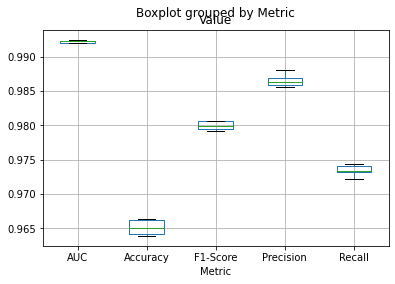

In [7]:
df_metrics.boxplot(column='Value', by='Metric')

In [8]:
print("\nMALE/FEMALE:")
sex_summary


MALE/FEMALE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,0.003377,0.001098
Equalised Odds,-0.006733,0.002519
False Positive Rate Balance,-0.016843,0.004642
Predictive Parity Difference,0.003206,0.000811
Statistical Parity Difference,-0.030415,0.068009


Note: you may need to restart the kernel to use updated packages.


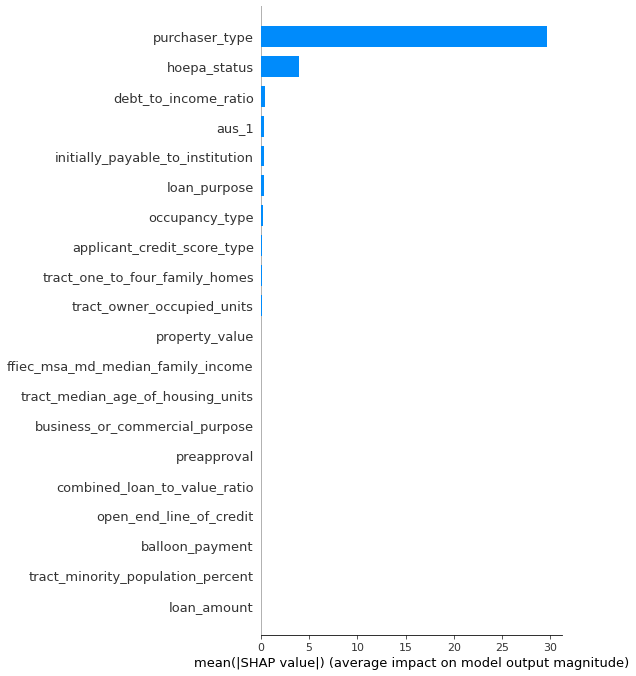

In [30]:
%pip install shap
import shap
explainer = shap.LinearExplainer(lr, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")



In [10]:
%pip install xgboost
from xgboost import XGBClassifier
# Initialize the XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False)

mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

import pandas as pd
k, i = True, 1

for (train, test) in mv.split(X, y):
    # fit model
    xgb_clf = xgb_clf.fit(X.iloc[train], y.iloc[train].values.ravel())
    
    # get predictions in the test set
    ypred_prob = xgb_clf.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = xgb_clf.predict(X.iloc[test])
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf in == "AUC":
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    sex_metrics = []
    for bias in bias_metrics.keys():                                  
        sex_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_e[test], group_f[test])])

        # Convert lists to DataFrames before concatenation
        sex_df = pd.DataFrame(sex_metrics, columns=["Metric", "Value"]).assign(Fold=i)

    # Concatenate the new DataFrames with the all metrics DataFrames
    sex_metrics_all = pd.concat([sex_metrics_all, sex_df], axis=0)

    i += 1

sex_summary = sex_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])

Note: you may need to restart the kernel to use updated packages.


In [11]:
# If 'Value' is not a numeric type, you may need to convert it
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

# Now try creating the pivot table again
pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


,mean,std
,Value,Value
Metric,,
AUC,0.994284,0.000218
Accuracy,0.969518,0.000781
F1-Score,0.982557,0.000443
Precision,0.983372,0.000761
Recall,0.981743,0.000351


<AxesSubplot:title={'center':'Value'}, xlabel='Metric'>

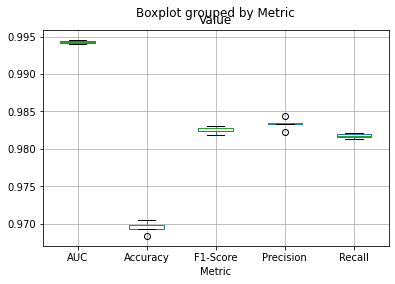

In [12]:
df_metrics.boxplot(column='Value', by='Metric')

In [13]:
print("\nMALE/FEMALE:")
sex_summary


MALE/FEMALE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,0.002909,0.001435
Equalised Odds,-0.007017,0.003278
False Positive Rate Balance,-0.016943,0.005562
Predictive Parity Difference,0.003276,0.001041
Statistical Parity Difference,-0.030415,0.064120


100%|===================| 105407/105529 [04:39<00:00]        

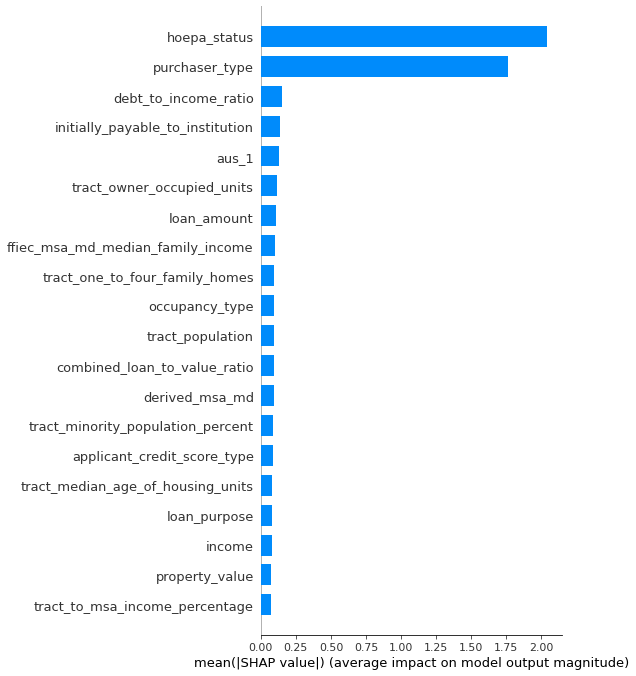

In [32]:

explainer = shap.TreeExplainer(xgb_clf, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")



In [14]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

import pandas as pd
k, i = True, 1

for (train, test) in mv.split(X, y):
    # fit model
    random_forest = random_forest.fit(X.iloc[train], y.iloc[train].values.ravel())
    
    # get predictions in the test set
    ypred_prob = random_forest.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = random_forest.predict(X.iloc[test])
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf == "AUC":
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    # compute performance metrics
    sex_metrics = []
    for bias in bias_metrics.keys():                                
        sex_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_e[test], group_f[test])])
        # Convert lists to DataFrames before concatenation
        sex_df = pd.DataFrame(sex_metrics, columns=["Metric", "Value"]).assign(Fold=i)
 

    # Concatenate the new DataFrames with the all metrics DataFrames
    sex_metrics_all = pd.concat([sex_metrics_all, sex_df], axis=0)

    i += 1

sex_summary = sex_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])

In [15]:
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


,mean,std
,Value,Value
Metric,,
AUC,0.994432,0.000245
Accuracy,0.969692,0.001039
F1-Score,0.982631,0.000597
Precision,0.984899,0.000546
Recall,0.980374,0.000688


<AxesSubplot:title={'center':'Value'}, xlabel='Metric'>

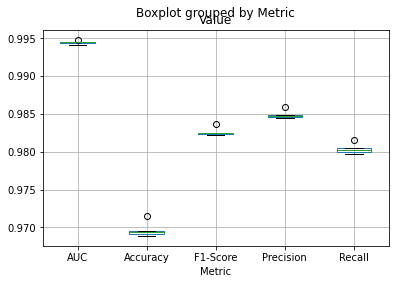

In [16]:
df_metrics.boxplot(column='Value', by='Metric')

In [17]:
print("\nMALE/FEMALE:")
sex_summary


MALE/FEMALE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,0.002541,0.001731
Equalised Odds,-0.006734,0.004461
False Positive Rate Balance,-0.016009,0.007856
Predictive Parity Difference,0.003137,0.001256
Statistical Parity Difference,-0.030415,0.062964


100%|===================| 211034/211058 [75:08<00:00]        

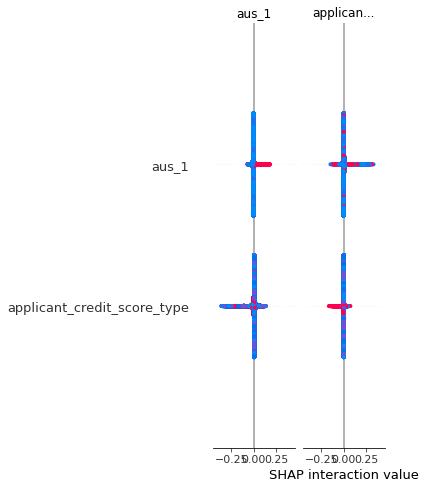

In [31]:

explainer = shap.TreeExplainer(random_forest, X_train)
shap_values = explainer.shap_values(X_train, check_additivity=False)
shap.summary_plot(shap_values, X_train, plot_type="bar")



In [18]:
import pandas as pd
k, i = True, 1

from sklearn import svm

svm = svm.SVC(random_state=10, probability=True)

for (train, test) in mv.split(X, y):
    svm = svm.fit(X.iloc[train], y.iloc[train].values.ravel())
    
    ypred_prob = svm.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = svm.predict(X.iloc[test])
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf == "AUC":
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

    sex_metrics = []
    for bias in bias_metrics.keys():                                   
        sex_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_e[test], group_f[test])])
        # Convert lists to DataFrames before concatenation
        sex_df = pd.DataFrame(sex_metrics, columns=["Metric", "Value"]).assign(Fold=i)


    # Concatenate the new DataFrames with the all metrics DataFrames
    sex_metrics_all = pd.concat([sex_metrics_all, sex_df], axis=0)

    i += 1

sex_summary = sex_metrics_all.pivot_table(index='Metric', values='Value', aggfunc=['mean', 'std'])

In [19]:
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


,mean,std
,Value,Value
Metric,,
AUC,0.991930,0.000371
Accuracy,0.965879,0.000893
F1-Score,0.980416,0.000508
Precision,0.984215,0.000899
Recall,0.976646,0.000560


<AxesSubplot:title={'center':'Value'}, xlabel='Metric'>

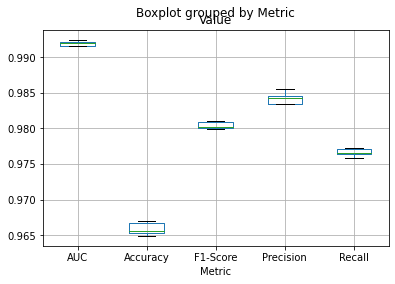

In [20]:
df_metrics.boxplot(column='Value', by='Metric')

In [21]:
print("\nMALE/FEMALE:")
sex_summary


MALE/FEMALE:


,mean,std
,Value,Value
Metric,,
Equal Opportunity Difference,0.002717,0.001713
Equalised Odds,-0.007491,0.005241
False Positive Rate Balance,-0.017700,0.009504
Predictive Parity Difference,0.003393,0.001365
Statistical Parity Difference,-0.030415,0.062410


In [ ]:

explainer = shap.LinearExplainer(svm, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")



In [26]:
import lightgbm as lgb
import numpy as np

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

lgb_model = lgb.train(parameters,
                  train_data,
                  valid_sets=[valid_data],
                  num_boost_round=5000)

mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

import pandas as pd
k, i = True, 1

for (train, test) in mv.split(X, y):
    # Create the LightGBM datasets for training and validation
    train_data = lgb.Dataset(X.iloc[train], label=y.iloc[train])
    valid_data = lgb.Dataset(X.iloc[test], label=y.iloc[test], reference=train_data)
    
    # Train the model
    lgb_model = lgb.train(parameters,
                          train_data,
                          valid_sets=[valid_data],
                          num_boost_round=5000)
    
    # Get the probability predictions on the test set
    ypred_prob = lgb_model.predict(X.iloc[test])  # get probabilities
    
    # Convert probabilities to binary class predictions
    ypred_class = (ypred_prob >= 0.5).astype(int)
    
    # Compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf == "AUC":
            metrics.append([pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)])
        else:
            metrics.append([pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)])

    # Concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    if k:
        df_metrics = df_m.copy()
        k = False
    else:
        df_metrics = pd.concat([df_metrics, df_m], axis=0, ignore_index=True)

    # Compute bias metrics
    sex_metrics = []
    for bias in bias_metrics.keys():
        sex_metrics.append([bias, bias_metrics[bias](y.iloc[test].values.ravel(), ypred_class,
                                        group_e[test], group_f[test])])
        
    sex_df = pd.DataFrame(sex_metrics, columns=["Metric", "Value"]).assign(Fold=i)
    if k:
        sex_metrics_all = sex_df.copy()
        k = False
    else:
        sex_metrics_all = pd.concat([sex_metrics_all, sex_df], axis=0)

    i += 1

sex_summary = sex_metrics_all.groupby('Metric')['Value'].agg(['mean', 'std'])


In [27]:
if not pd.api.types.is_numeric_dtype(df_metrics['Value']):
    df_metrics['Value'] = pd.to_numeric(df_metrics['Value'], errors='coerce')

pivot_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])


,mean,std
,Value,Value
Metric,,
AUC,0.993813,0.000227
Accuracy,0.967190,0.000723
F1-Score,0.981090,0.000409
Precision,0.989059,0.000922
Recall,0.973248,0.000366


<AxesSubplot:title={'center':'Value'}, xlabel='Metric'>

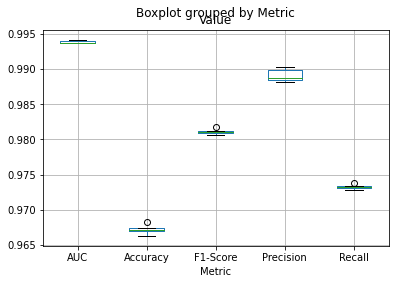

In [28]:
df_metrics.boxplot(column='Value', by='Metric')

In [29]:
print("\nMALE/FEMALE:")
sex_summary


MALE/FEMALE:


,mean,std
Metric,,
Equal Opportunity Difference,0.003062,0.001842
Equalised Odds,-0.006750,0.005514
False Positive Rate Balance,-0.016561,0.010013
Predictive Parity Difference,0.003192,0.001464
Statistical Parity Difference,-0.030415,0.062084


In [ ]:

explainer = shap.TreeExplainer(lgb_model, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")